# Notebook 6: Training, Generation, and Scaling

The final notebook. We take the GPT model from Notebook 5 and:

1. **Train it properly** with learning rate scheduling, gradient clipping, and AdamW
2. **Visualize training dynamics** with loss curves, LR schedules, and token-level analysis
3. **Generate text** and explore temperature / top-k sampling
4. **Scale up** from tiny to small and compare quality
5. **Final ablation** comparing every model we have built across all 6 notebooks

| Notebook | What We Built |
|----------|--------------|
| **01** | BPE Tokenizer |
| **02** | Bigram Baseline |
| **03** | Self-Attention (single + multi-head) |
| **04** | Transformer Block (FFN + LayerNorm + Residuals) |
| **05** | Full GPT Model (config, weight tying, init) |
| **06** | **Training, Generation, and Scaling (this notebook)** |

In [12]:
import os
import re
import json
import math
import time
from dataclasses import dataclass
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

# --- BPE Tokenizer (from Notebook 1, with fast encode) ---

def _pre_tokenize(text):
    pattern = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+| ?[^\s\w]+|\s+")
    return [chunk.encode("utf-8") for chunk in pattern.findall(text)]

def merge_pair(token_ids, pair, new_id):
    merged = []
    i = 0
    while i < len(token_ids):
        if i < len(token_ids) - 1 and (token_ids[i], token_ids[i + 1]) == pair:
            merged.append(new_id)
            i += 2
        else:
            merged.append(token_ids[i])
            i += 1
    return merged

class BPETokenizer:
    def __init__(self, merges, vocab):
        self.merges = merges
        self.vocab = vocab
    @property
    def vocab_size(self):
        return len(self.vocab)
    def encode(self, text):
        chunks = _pre_tokenize(text)
        all_ids = []
        for chunk in chunks:
            word = list(chunk)
            for pair, new_id in self.merges:
                word = merge_pair(word, pair, new_id)
            all_ids.extend(word)
        return all_ids
    def decode(self, token_ids):
        return b"".join(self.vocab[id] for id in token_ids).decode("utf-8", errors="replace")
    @classmethod
    def load(cls, path):
        with open(path) as f:
            data = json.load(f)
        merges = [((a, b), new_id) for [a, b], new_id in data["merges"]]
        vocab = {int(k): bytes(v) for k, v in data["vocab"].items()}
        return cls(merges, vocab)

# --- GPTConfig ---
@dataclass
class GPTConfig:
    vocab_size: int = 512
    block_size: int = 128
    n_layers: int = 4
    n_heads: int = 4
    d_model: int = 128
    d_ff: int = 512
    dropout: float = 0.1
    def __post_init__(self):
        assert self.d_model % self.n_heads == 0

# --- Transformer components (from Notebooks 3-5) ---
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_heads = config.n_heads
        self.d_k = config.d_model // config.n_heads
        self.W_qkv = nn.Linear(config.d_model, 3 * config.d_model, bias=False)
        self.W_o = nn.Linear(config.d_model, config.d_model, bias=False)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size)))
    def forward(self, x):
        B, T, C = x.shape
        qkv = self.W_qkv(x)
        Q, K, V = qkv.chunk(3, dim=-1)
        Q = Q.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        attn = (Q @ K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn = attn.masked_fill(self.mask[:T, :T] == 0, float("-inf"))
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        out = (attn @ V).transpose(1, 2).contiguous().view(B, T, C)
        return self.resid_dropout(self.W_o(out))

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.d_model, config.d_ff),
            nn.GELU(),
            nn.Linear(config.d_ff, config.d_model),
            nn.Dropout(config.dropout),
        )
    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.d_model)
        self.attn = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config.d_model)
        self.ffn = FeedForward(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_emb = nn.Embedding(config.block_size, config.d_model)
        self.drop = nn.Dropout(config.dropout)
        self.blocks = nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layers)])
        self.ln_f = nn.LayerNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)
        self.token_emb.weight = self.lm_head.weight
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith("W_o.weight") or pn.endswith("net.2.weight"):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layers))
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.drop(self.token_emb(idx) + self.pos_emb(torch.arange(T, device=idx.device)))
        for block in self.blocks:
            x = block(x)
        logits = self.lm_head(self.ln_f(x))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float("-inf")
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}" + (" (GPU detected!)" if device.type != 'cpu' else " (CPU -- training will be slow)"))
print("All modules loaded (Tokenizer, GPTConfig, GPT model).")

PyTorch version: 2.10.0
Device: mps (GPU detected!)
All modules loaded (Tokenizer, GPTConfig, GPT model).


## 1. Setup: Data and Configuration

In [13]:
# Load tokenizer and data
tokenizer = BPETokenizer.load(os.path.join("..", "data", "bpe_tokenizer.json"))
with open(os.path.join("..", "data", "tinyshakespeare.txt")) as f:
    raw_text = f.read()

full_data = torch.tensor(tokenizer.encode(raw_text), dtype=torch.long)
split_idx = int(0.9 * len(full_data))
train_data, val_data = full_data[:split_idx], full_data[split_idx:]

print(f"Dataset: {len(raw_text):,} characters -> {len(full_data):,} tokens")
print(f"Train: {len(train_data):,} tokens | Val: {len(val_data):,} tokens")
print(f"Vocab: {tokenizer.vocab_size} tokens")
print(f"Compression: {len(raw_text) / len(full_data):.2f} chars/token")

Dataset: 1,115,394 characters -> 568,603 tokens
Train: 511,742 tokens | Val: 56,861 tokens
Vocab: 512 tokens
Compression: 1.96 chars/token


## 2. Learning Rate Schedule: Warmup + Cosine Decay

Modern LLM training uses a carefully designed learning rate schedule:

1. **Linear warmup** (first ~5-10% of training): gradually increase LR from 0 to peak. This prevents early training instability when weights are still random.
2. **Cosine decay**: smoothly decrease LR following a cosine curve. This allows fine-grained learning in later stages.

This is the standard schedule used by GPT-2, GPT-3, LLaMA, and essentially all modern LLMs.

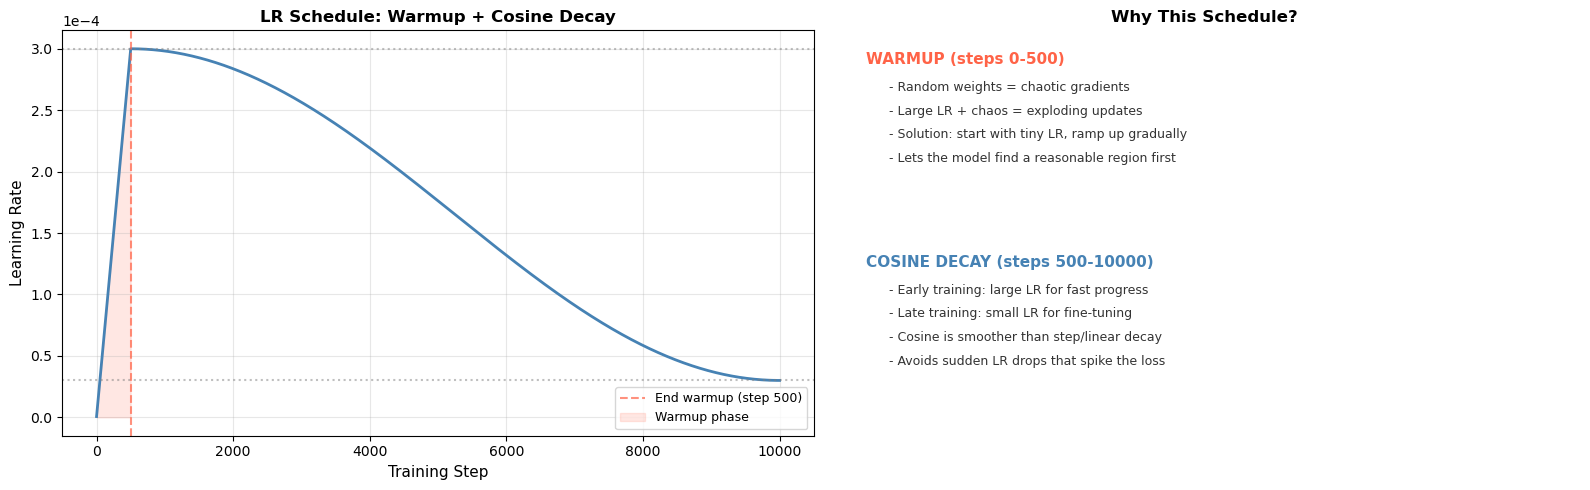

Schedule: warmup 500 steps, then cosine decay over 10000 steps
  Peak LR: 3.0e-04 | Min LR: 3.0e-05 | Ratio: 10x


In [14]:
def get_lr(step, warmup_steps, max_steps, max_lr, min_lr):
    """Learning rate with linear warmup then cosine decay."""
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    decay_ratio = min(decay_ratio, 1.0)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

# Visualize the schedule
max_steps = 10000
warmup_steps = 500
max_lr = 3e-4
min_lr = 3e-5

lrs = [get_lr(s, warmup_steps, max_steps, max_lr, min_lr) for s in range(max_steps)]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Full schedule ---
ax = axes[0]
ax.plot(range(max_steps), lrs, color='steelblue', linewidth=2)
ax.axvline(x=warmup_steps, color='tomato', linestyle='--', alpha=0.7, label=f'End warmup (step {warmup_steps})')
ax.axhline(y=max_lr, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=min_lr, color='gray', linestyle=':', alpha=0.5)
ax.fill_between(range(warmup_steps), 0, [lrs[i] for i in range(warmup_steps)],
                alpha=0.15, color='tomato', label='Warmup phase')
ax.set_xlabel('Training Step', fontsize=11)
ax.set_ylabel('Learning Rate', fontsize=11)
ax.set_title('LR Schedule: Warmup + Cosine Decay', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(-4, -4))

# --- Why warmup? ---
ax = axes[1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')
ax.set_title('Why This Schedule?', fontsize=12, fontweight='bold')

explanations = [
    (5.5, 'WARMUP (steps 0-500)', 'tomato', [
        'Random weights = chaotic gradients',
        'Large LR + chaos = exploding updates',
        'Solution: start with tiny LR, ramp up gradually',
        'Lets the model find a reasonable region first',
    ]),
    (2.5, 'COSINE DECAY (steps 500-10000)', 'steelblue', [
        'Early training: large LR for fast progress',
        'Late training: small LR for fine-tuning',
        'Cosine is smoother than step/linear decay',
        'Avoids sudden LR drops that spike the loss',
    ]),
]

for y_start, title, color, points in explanations:
    ax.text(0.5, y_start, title, fontsize=11, fontweight='bold', color=color)
    for j, point in enumerate(points):
        ax.text(0.8, y_start - 0.4 - j * 0.35, f'- {point}', fontsize=9, color='#333')

plt.tight_layout()
plt.show()

print(f"Schedule: warmup {warmup_steps} steps, then cosine decay over {max_steps} steps")
print(f"  Peak LR: {max_lr:.1e} | Min LR: {min_lr:.1e} | Ratio: {max_lr/min_lr:.0f}x")

## 3. Full Training Loop

Our training loop includes everything a real LLM training run needs:
- **AdamW optimizer** with weight decay (regularization)
- **Gradient clipping** to prevent exploding gradients
- **Periodic evaluation** on held-out validation data
- **Sample generation** during training to watch the model improve

In [15]:
def get_batch(split, block_size, batch_size):
    d = train_data if split == "train" else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i + block_size] for i in ix]).to(device)
    y = torch.stack([d[i + 1:i + block_size + 1] for i in ix]).to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model, block_size, batch_size, eval_iters=100):
    model.eval()
    losses = {}
    for split in ["train", "val"]:
        total = 0.0
        for _ in range(eval_iters):
            xb, yb = get_batch(split, block_size, batch_size)
            _, loss = model(xb, yb)
            total += loss.item()
        losses[split] = total / eval_iters
    model.train()
    return losses

def train_gpt(config, max_steps=10000, batch_size=32, max_lr=3e-4, min_lr=3e-5,
              warmup_steps=500, eval_interval=500, grad_clip=1.0, sample_interval=2000):
    """Full GPT training with LR schedule, gradient clipping, and periodic eval."""
    torch.manual_seed(42)
    model = GPT(config).to(device)
    n_params = sum(p.numel() for p in model.parameters())

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=max_lr, betas=(0.9, 0.95), weight_decay=0.1
    )

    print(f"Training GPT ({n_params:,} params) on {device}")
    print(f"  Config: d_model={config.d_model}, n_layers={config.n_layers}, "
          f"n_heads={config.n_heads}, block_size={config.block_size}")
    print(f"  Schedule: {max_steps} steps, warmup={warmup_steps}, "
          f"lr={max_lr}->{min_lr}, grad_clip={grad_clip}")
    print(f"  Batch: {batch_size} x {config.block_size} = {batch_size * config.block_size:,} tokens/step")
    print()
    print(f"{'Step':>6} {'Train':>8} {'Val':>8} {'LR':>10} {'Time':>8}")
    print("-" * 44)

    step_losses = []  # (step, loss) for every step
    eval_train_losses, eval_val_losses, eval_steps = [], [], []
    lr_history = []
    t0 = time.time()

    for step in range(max_steps):
        lr = get_lr(step, warmup_steps, max_steps, max_lr, min_lr)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        lr_history.append(lr)

        if step % eval_interval == 0 or step == max_steps - 1:
            losses = estimate_loss(model, config.block_size, batch_size)
            eval_train_losses.append(losses["train"])
            eval_val_losses.append(losses["val"])
            eval_steps.append(step)
            elapsed = time.time() - t0
            print(f"{step:>6} {losses['train']:>8.4f} {losses['val']:>8.4f} {lr:>10.2e} {elapsed:>7.1f}s")

        if step > 0 and step % sample_interval == 0:
            model.eval()
            start = torch.zeros((1, 1), dtype=torch.long, device=device)
            gen = model.generate(start, max_new_tokens=100, temperature=0.8, top_k=40)
            print(f"  >> {tokenizer.decode(gen[0].tolist())[:120]}...")
            model.train()

        xb, yb = get_batch("train", config.block_size, batch_size)
        _, loss = model(xb, yb)
        step_losses.append((step, loss.item()))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        if grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

    total_time = time.time() - t0
    print(f"\nDone in {total_time:.1f}s ({total_time/60:.1f}m)")
    print(f"Final: train={eval_train_losses[-1]:.4f}, val={eval_val_losses[-1]:.4f}")

    history = {
        "step_losses": step_losses,
        "eval_steps": eval_steps,
        "eval_train": eval_train_losses,
        "eval_val": eval_val_losses,
        "lr_history": lr_history,
    }
    return model, history

print("Training infrastructure ready.")
print("  get_batch() - sample random training windows")
print("  estimate_loss() - average loss over many batches")
print("  train_gpt() - full training loop with schedule + clipping")

Training infrastructure ready.
  get_batch() - sample random training windows
  estimate_loss() - average loss over many batches
  train_gpt() - full training loop with schedule + clipping


## 4. Train the Tiny Model

First, we train our smallest config (4 layers, 128 d_model, ~870K params). This is fast enough to iterate on CPU and verify everything works.

In [16]:
tiny_config = GPTConfig(
    vocab_size=tokenizer.vocab_size,
    block_size=128, n_layers=4, n_heads=4, d_model=128, d_ff=512, dropout=0.1,
)

model_tiny, history_tiny = train_gpt(
    tiny_config, max_steps=5000, batch_size=32, max_lr=3e-4, warmup_steps=300,
    eval_interval=500, sample_interval=2000
)

Training GPT (873,216 params) on mps
  Config: d_model=128, n_layers=4, n_heads=4, block_size=128
  Schedule: 5000 steps, warmup=300, lr=0.0003->3e-05, grad_clip=1.0
  Batch: 32 x 128 = 4,096 tokens/step

  Step    Train      Val         LR     Time
--------------------------------------------
     0   6.2590   6.2535   1.00e-06     4.5s
   500   3.7331   3.7984   2.99e-04    31.2s
  1000   3.3899   3.5620   2.85e-04    50.0s
  1500   3.1512   3.3973   2.59e-04    76.6s
  2000   2.9798   3.2556   2.22e-04   103.2s
  >>  ,
I than an the grace!
Come, they? impearshy? Ay! Daught is my death!

First Gentled:
Where is that I day, Anctagned fr...
  2500   2.8673   3.1724   1.79e-04   148.2s
  3000   2.7867   3.1083   1.34e-04   175.2s
  3500   2.7372   3.0692   9.24e-05   199.3s
  4000   2.6969   3.0352   5.91e-05   215.0s
  >>  .

BUCKINGHAM:
Will I chide, might will be some so.

BUCKINGHAM:
Stand in the death and this crown.

HASTINGS:
Bondon y...
  4500   2.6798   3.0105   3.75e-05   232.

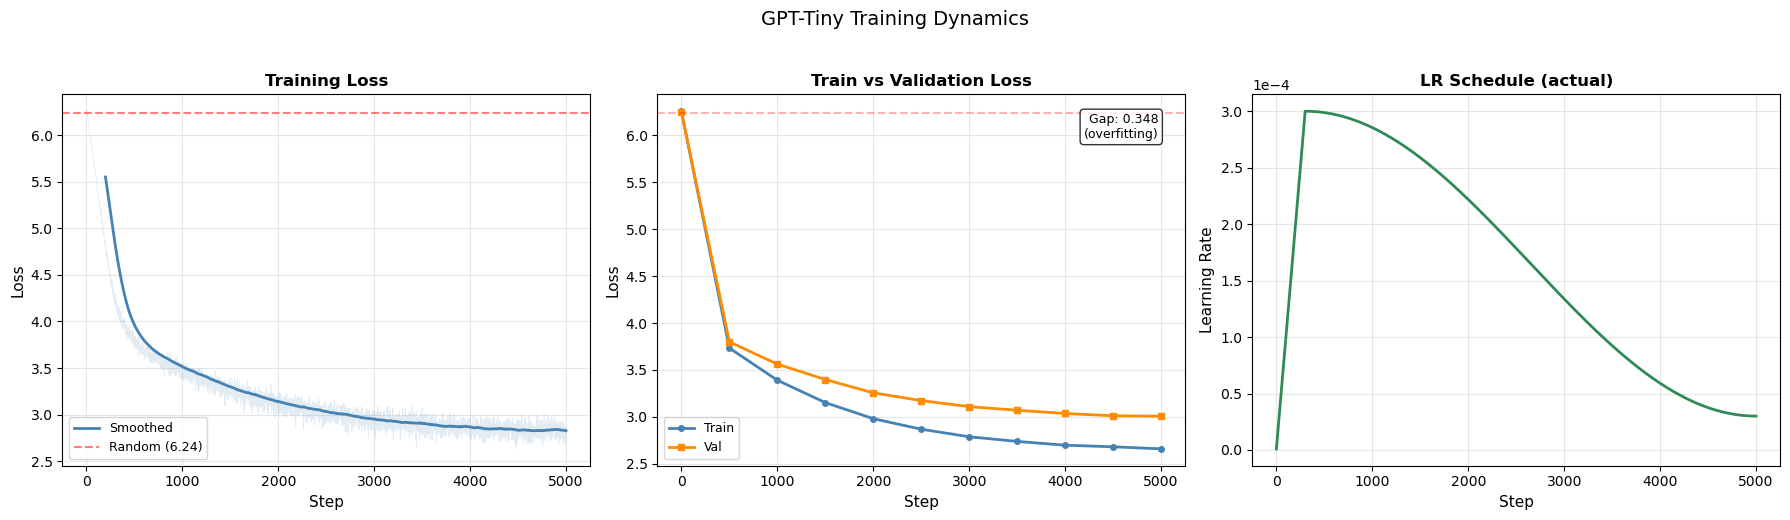

Final loss: train=2.6580, val=3.0062
Improvement over random: 51.8%
Train-val gap: 0.3482 (healthy)


In [17]:
# Visualize training dynamics

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Panel 1: Training loss (raw + smoothed) ---
ax = axes[0]
steps = [s for s, _ in history_tiny["step_losses"]]
losses = [l for _, l in history_tiny["step_losses"]]
ax.plot(steps, losses, color='steelblue', alpha=0.15, linewidth=0.5)
# Smoothed
window = 200
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    ax.plot(steps[window-1:], smoothed, color='steelblue', linewidth=2, label='Smoothed')

random_loss = math.log(tiny_config.vocab_size)
ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.5, label=f'Random ({random_loss:.2f})')
ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 2: Train vs Val ---
ax = axes[1]
ax.plot(history_tiny["eval_steps"], history_tiny["eval_train"], 'o-', color='steelblue',
        linewidth=2, markersize=4, label='Train')
ax.plot(history_tiny["eval_steps"], history_tiny["eval_val"], 's-', color='darkorange',
        linewidth=2, markersize=4, label='Val')
ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.3)
ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Train vs Validation Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Gap analysis
gap = history_tiny["eval_train"][-1] - history_tiny["eval_val"][-1]
ax.text(0.95, 0.95, f'Gap: {abs(gap):.3f}\n({"overfitting" if gap < -0.1 else "healthy"})',
        transform=ax.transAxes, ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# --- Panel 3: Learning rate ---
ax = axes[2]
ax.plot(range(len(history_tiny["lr_history"])), history_tiny["lr_history"],
        color='seagreen', linewidth=2)
ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('Learning Rate', fontsize=11)
ax.set_title('LR Schedule (actual)', fontsize=12, fontweight='bold')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(-4, -4))
ax.grid(True, alpha=0.3)

plt.suptitle('GPT-Tiny Training Dynamics', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

final_train = history_tiny["eval_train"][-1]
final_val = history_tiny["eval_val"][-1]
print(f"Final loss: train={final_train:.4f}, val={final_val:.4f}")
print(f"Improvement over random: {(1 - final_val/random_loss)*100:.1f}%")
print(f"Train-val gap: {abs(final_train - final_val):.4f} ({'healthy' if abs(final_train - final_val) < 0.5 else 'overfitting'})")

## 5. Text Generation: Sampling Strategies

The model is trained. Now let us generate text and explore how **temperature** and **top-k** affect the output.

### Temperature
Scales logits before softmax:
- **T < 1**: sharper distribution (more confident, more repetitive)
- **T = 1**: as-trained distribution
- **T > 1**: flatter distribution (more creative, more chaotic)

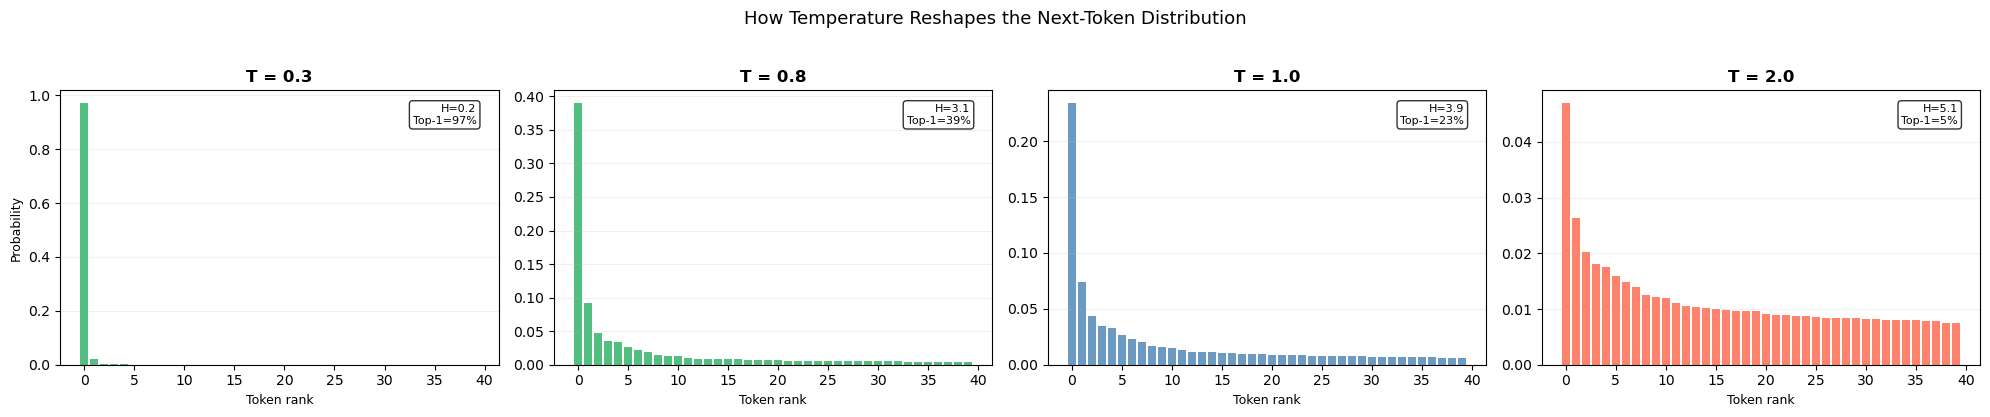

Low temp (0.3): peaked -- model picks the 'safest' token almost every time
Medium (0.8):   good balance of coherence and variety
Standard (1.0): as-trained distribution
High (2.0):     very flat -- nearly random sampling, often incoherent


In [18]:
# Visualize temperature effect on the probability distribution

model_tiny.eval()
sample_ids = tokenizer.encode("ROMEO:\nBut soft")[:tiny_config.block_size]
with torch.no_grad():
    logits, _ = model_tiny(torch.tensor([sample_ids], device=device))
    raw_logits = logits[0, -1, :].cpu()
model_tiny.train()

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
temperatures = [0.3, 0.8, 1.0, 2.0]

for col, temp in enumerate(temperatures):
    ax = axes[col]
    scaled = raw_logits / temp
    probs = F.softmax(scaled, dim=-1).numpy()
    sorted_idx = np.argsort(probs)[::-1]
    top_probs = probs[sorted_idx[:40]]
    top_tokens = [tokenizer.vocab[int(i)].decode('utf-8', errors='replace').strip()[:6]
                  for i in sorted_idx[:40]]

    color = '#27ae60' if temp < 1 else ('steelblue' if temp == 1 else 'tomato')
    ax.bar(range(40), top_probs, color=color, edgecolor='none', alpha=0.8)
    ax.set_title(f'T = {temp}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Token rank', fontsize=9)
    if col == 0:
        ax.set_ylabel('Probability', fontsize=9)

    entropy = -np.sum(probs * np.log(probs + 1e-10))
    ax.text(0.95, 0.95, f'H={entropy:.1f}\nTop-1={top_probs[0]:.0%}',
            transform=ax.transAxes, ha='right', va='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, alpha=0.2, axis='y')

plt.suptitle('How Temperature Reshapes the Next-Token Distribution', fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

print("Low temp (0.3): peaked -- model picks the 'safest' token almost every time")
print("Medium (0.8):   good balance of coherence and variety")
print("Standard (1.0): as-trained distribution")
print("High (2.0):     very flat -- nearly random sampling, often incoherent")

In [19]:
# Generate text at different temperatures
print("=" * 70)
print("TEMPERATURE COMPARISON (top_k=40)")
print("=" * 70)

model_tiny.eval()
for temp in [0.5, 0.8, 1.0, 1.5]:
    print(f"\n--- Temperature = {temp} ---")
    start = torch.zeros((1, 1), dtype=torch.long, device=device)
    gen = model_tiny.generate(start, max_new_tokens=200, temperature=temp, top_k=40)
    print(tokenizer.decode(gen[0].tolist()))
model_tiny.train()

print("\n" + "=" * 70)
print("Lower temperature = more repetitive but coherent")
print("Higher temperature = more creative but potentially nonsensical")

TEMPERATURE COMPARISON (top_k=40)

--- Temperature = 0.5 ---
 
Thererms, but that here. or heaven, I hold me,
As before you to be so, I'll make it.

LEONTES:
What is't?

LADY ANNE:
If you make it; for I'll say.

DUKE VINCENTIO:
Then, marry,
So come.

LEONTES:
No, marry,
Are you do; I am proved.

AUTOLYCUS:
I'll not speak.

POLIXENES:
It is the duke; and I'll hear him:
I'll not report.

MENENIUS:
My lord, come

--- Temperature = 0.8 ---
  hus

HENRY BUMIO:
His hoft thou, I warrant you.

ROMEO:
When thought he is here slew in the world;
And by Tybalt, thou much being the world;
Thank it is my liege.

PRINCE:
What is this?

COMINIUS:
Vercates are a mock of your king
Thanks, I know but a greetty?
The wors of this name!

MENENIUS:
Why, before this bet,
Ay, as you shall be part, whithaless,
The fair majesty; but my grave,

--- Temperature = 1.0 ---
  a bary that hand.
th, but he were me, fear not lecture for our tongue; weep
And we make your obdel in our sistersolved
Now, the way I know you 

### Top-k Sampling

Instead of sampling from all 512 tokens, top-k limits the choice to the k most likely tokens. This prevents the model from ever picking very unlikely tokens (which cause gibberish).

In [20]:
# Generate text at different top-k values
print("=" * 70)
print("TOP-K COMPARISON (temperature=0.8)")
print("=" * 70)

model_tiny.eval()
for k in [1, 5, 20, 100]:
    label = f"top_k={k}" if k > 1 else "top_k=1 (greedy)"
    print(f"\n--- {label} ---")
    start = torch.zeros((1, 1), dtype=torch.long, device=device)
    gen = model_tiny.generate(start, max_new_tokens=200, temperature=0.8, top_k=k)
    print(tokenizer.decode(gen[0].tolist()))
model_tiny.train()

print("\nk=1 (greedy): deterministic, often gets stuck in loops")
print("k=5: very constrained, repetitive but grammatical")
print("k=20: good balance -- the 'sweet spot' for most models")
print("k=100: wide open -- occasionally picks unlikely tokens")

TOP-K COMPARISON (temperature=0.8)

--- top_k=1 (greedy) ---
 ,
Why, I have I have been, and here,
Where you must be against the world, and they are
Which I have been against their country's son,
And I have been against their country's son,
And, and then, and they have been against their
With all their poor slains, and their provost,
And make their provost, and then,
And make against their people,
And some proved their people,
And let himself to the joy.

LADY ANNE:
If you, my lord,
I

--- top_k=5 ---
 ,
Why, that is thens toove I must I say
Why, I'll say, for they have I have,
Attter take a sword of your son,
Which I will not been perforce.

POLIXENES:
Nay, I have art a poor some
As were in the world of his charity,
Stand to better time, and setime,
And make himself to out of his father's brother.
No, these says, I am saw,
In keep him, and then, or the justice,
Is here, and they have done to the course

--- top_k=20 ---
 
To me that a man; which you,
Which you, sir, I chrue, a grace.


## 6. Scale Up: Training a Larger Model

Now the real test: does making the model bigger actually help? We will train a **small** config (8 layers, 256 d_model) and compare.

This will take longer on CPU, but the quality difference should be visible in both loss and generated text.

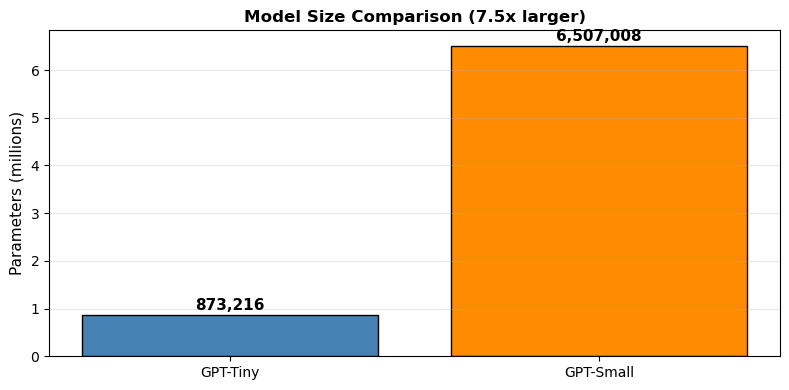

GPT-Tiny:     873,216 params | d=128, 4L, 4H, ctx=128
GPT-Small:  6,507,008 params | d=256, 8L, 8H, ctx=256

Small is 7.5x larger. Training will be ~7x slower per step.


In [21]:
# Define the small config
small_config = GPTConfig(
    vocab_size=tokenizer.vocab_size,
    block_size=256, n_layers=8, n_heads=8, d_model=256, d_ff=1024, dropout=0.1,
)

n_tiny = sum(p.numel() for p in model_tiny.parameters())
n_small = sum(p.numel() for p in GPT(small_config).parameters())

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(['GPT-Tiny', 'GPT-Small'], [n_tiny / 1e6, n_small / 1e6],
              color=['steelblue', 'darkorange'], edgecolor='black')
for bar, n in zip(bars, [n_tiny, n_small]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{n:,.0f}', ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel('Parameters (millions)', fontsize=11)
ax.set_title(f'Model Size Comparison ({n_small/n_tiny:.1f}x larger)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"GPT-Tiny:  {n_tiny:>10,} params | d={tiny_config.d_model}, {tiny_config.n_layers}L, {tiny_config.n_heads}H, ctx={tiny_config.block_size}")
print(f"GPT-Small: {n_small:>10,} params | d={small_config.d_model}, {small_config.n_layers}L, {small_config.n_heads}H, ctx={small_config.block_size}")
print(f"\nSmall is {n_small/n_tiny:.1f}x larger. Training will be ~{n_small/n_tiny:.0f}x slower per step.")

In [22]:
# Train the small model
model_small, history_small = train_gpt(
    small_config, max_steps=5000, batch_size=16, max_lr=3e-4, warmup_steps=300,
    eval_interval=500, sample_interval=2000
)

Training GPT (6,507,008 params) on mps
  Config: d_model=256, n_layers=8, n_heads=8, block_size=256
  Schedule: 5000 steps, warmup=300, lr=0.0003->3e-05, grad_clip=1.0
  Batch: 16 x 256 = 4,096 tokens/step

  Step    Train      Val         LR     Time
--------------------------------------------
     0   6.2918   6.2909   1.00e-06     9.6s
   500   3.4928   3.6603   2.99e-04    92.5s
  1000   3.0401   3.2926   2.85e-04   175.7s
  1500   2.6745   3.0586   2.59e-04   313.5s
  2000   2.4793   2.9359   2.22e-04   468.2s
  >>  ,
Therein these hath mighty in my wrong,
His noble lacks men, my scarford; and so I revenge
Of that I'll came it to the...
  2500   2.3217   2.8788   1.79e-04   647.1s
  3000   2.2089   2.8374   1.34e-04   815.6s
  3500   2.1315   2.8177   9.24e-05   969.4s
  4000   2.0341   2.8435   5.91e-05  1126.9s
  >>   Northumberland,
This hundred set down his lip day of heaven,
That, like foughted as little grave,
To leave forth the D...
  4500   1.9807   2.8380   3.75e-05  128

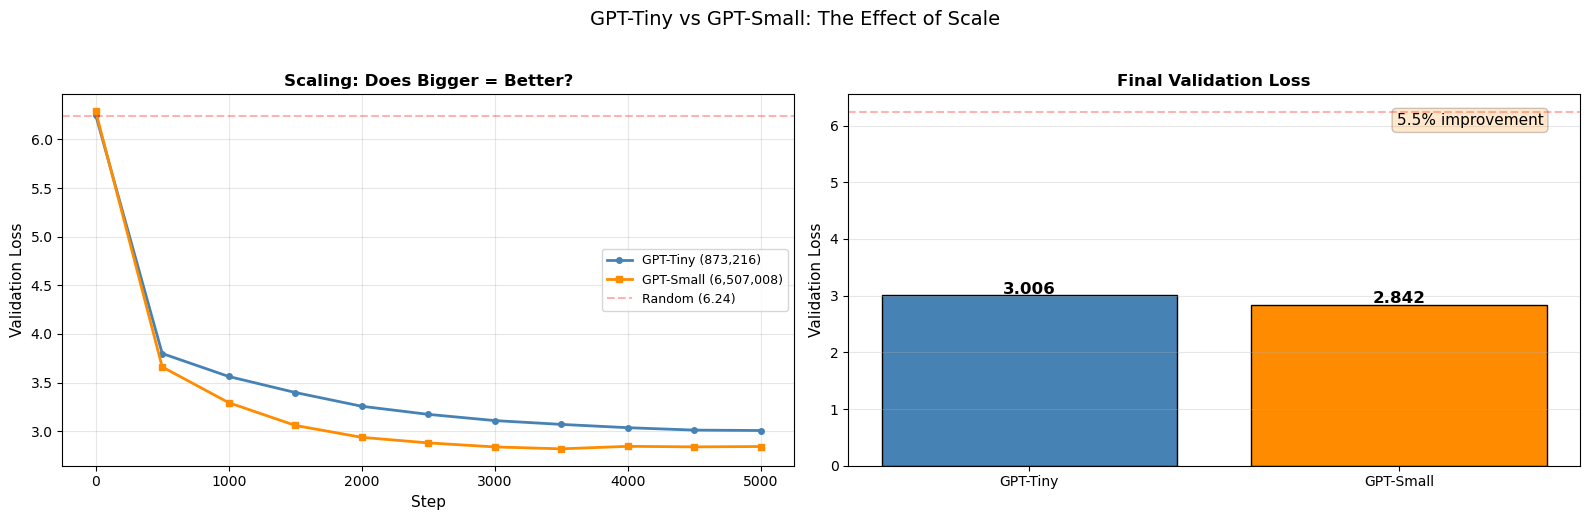

GPT-Tiny  val loss: 3.0062 (873,216 params)
GPT-Small val loss: 2.8415 (6,507,008 params)
Improvement: 5.5% lower loss with 7.5x more parameters

This is the scaling law in action: more parameters = lower loss, given enough data.


In [23]:
# Compare training curves: tiny vs small

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Validation loss ---
ax = axes[0]
ax.plot(history_tiny["eval_steps"], history_tiny["eval_val"], 'o-', color='steelblue',
        linewidth=2, markersize=4, label=f'GPT-Tiny ({n_tiny:,})')
ax.plot(history_small["eval_steps"], history_small["eval_val"], 's-', color='darkorange',
        linewidth=2, markersize=4, label=f'GPT-Small ({n_small:,})')

random_loss = math.log(tiny_config.vocab_size)
ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.3, label=f'Random ({random_loss:.2f})')
ax.set_xlabel('Step', fontsize=11)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Scaling: Does Bigger = Better?', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Bar comparison ---
ax = axes[1]
val_tiny = history_tiny["eval_val"][-1]
val_small = history_small["eval_val"][-1]

bars = ax.bar(['GPT-Tiny', 'GPT-Small'], [val_tiny, val_small],
              color=['steelblue', 'darkorange'], edgecolor='black')
for bar, v in zip(bars, [val_tiny, val_small]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{v:.3f}', ha='center', fontsize=12, fontweight='bold')

ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.3)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Final Validation Loss', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

improvement = (val_tiny - val_small) / val_tiny * 100
ax.text(0.95, 0.95, f'{improvement:.1f}% improvement',
        transform=ax.transAxes, ha='right', va='top', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='darkorange', alpha=0.2))

plt.suptitle('GPT-Tiny vs GPT-Small: The Effect of Scale', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

print(f"GPT-Tiny  val loss: {val_tiny:.4f} ({n_tiny:,} params)")
print(f"GPT-Small val loss: {val_small:.4f} ({n_small:,} params)")
print(f"Improvement: {improvement:.1f}% lower loss with {n_small/n_tiny:.1f}x more parameters")
print(f"\nThis is the scaling law in action: more parameters = lower loss, given enough data.")

In [24]:
# Generate from the small model
print("=" * 70)
print("GPT-SMALL: Generated Shakespeare")
print("=" * 70)

model_small.eval()
for i in range(3):
    start = torch.zeros((1, 1), dtype=torch.long, device=device)
    gen = model_small.generate(start, max_new_tokens=300, temperature=0.8, top_k=40)
    print(f"\n--- Sample {i+1} ---")
    print(tokenizer.decode(gen[0].tolist()))
model_small.train()

GPT-SMALL: Generated Shakespeare

--- Sample 1 ---
  to Henry's death;
But now to London, because thy state,
Yet here, indeed, thou shalt till thyself,
With all thy father, thy handsh rather hand.
Being heaven, I will wish thee to thy love
To make me before I hereafter:
Well thou revenged thy heart, and except.
Who shall we enter in foe
And make these army will have won our worthy wrongs,
And tell the king, whose impresses of their lives,
Which embraced in the purpose, whose strength,
Which in the battles do make me leave their stigs,
It shall be endured with their place:
Therefore I have heard of my love, I take it.
Now, good friend, my lord, the ears is proceed.
If they were they we

--- Sample 2 ---
 , by this Angelo:
Why, 'tis the time to be just, as toward,
Tell him to this offence; he must strike
As I have done, that he is but most unhappy
All towards Henry the order,
He that is forced
To Plantagenet, hereafter in Bohemia.

PAULINA:
For being won.
Well, this is your needful time,

GPT(
  (token_emb): Embedding(512, 256)
  (pos_emb): Embedding(256, 256)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (W_qkv): Linear(in_features=256, out_features=768, bias=False)
        (W_o): Linear(in_features=256, out_features=256, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, 

## 7. Final Ablation: The Complete Picture

The moment of truth. Let us compare **every model variant** we built across all 6 notebooks — from the context-blind bigram to the full GPT with proper training.

In [25]:
# Load all previous metrics and add GPT results
metrics_path = os.path.join("..", "data", "ablation_metrics.json")
with open(metrics_path) as f:
    all_metrics = json.load(f)

# Add GPT results
for name, model_obj, history, config in [
    ("GPT-Tiny (full)", model_tiny, history_tiny, tiny_config),
    ("GPT-Small (full)", model_small, history_small, small_config),
]:
    all_metrics = [m for m in all_metrics if m["model"] != name]
    all_metrics.append({
        "model": name,
        "parameters": sum(p.numel() for p in model_obj.parameters()),
        "val_loss": history["eval_val"][-1],
        "d_model": config.d_model,
        "n_layers": config.n_layers,
        "n_heads": config.n_heads,
        "block_size": config.block_size,
    })

with open(metrics_path, "w") as f:
    json.dump(all_metrics, f, indent=2)

print(f"Saved {len(all_metrics)} model results to ablation_metrics.json")

Saved 9 model results to ablation_metrics.json


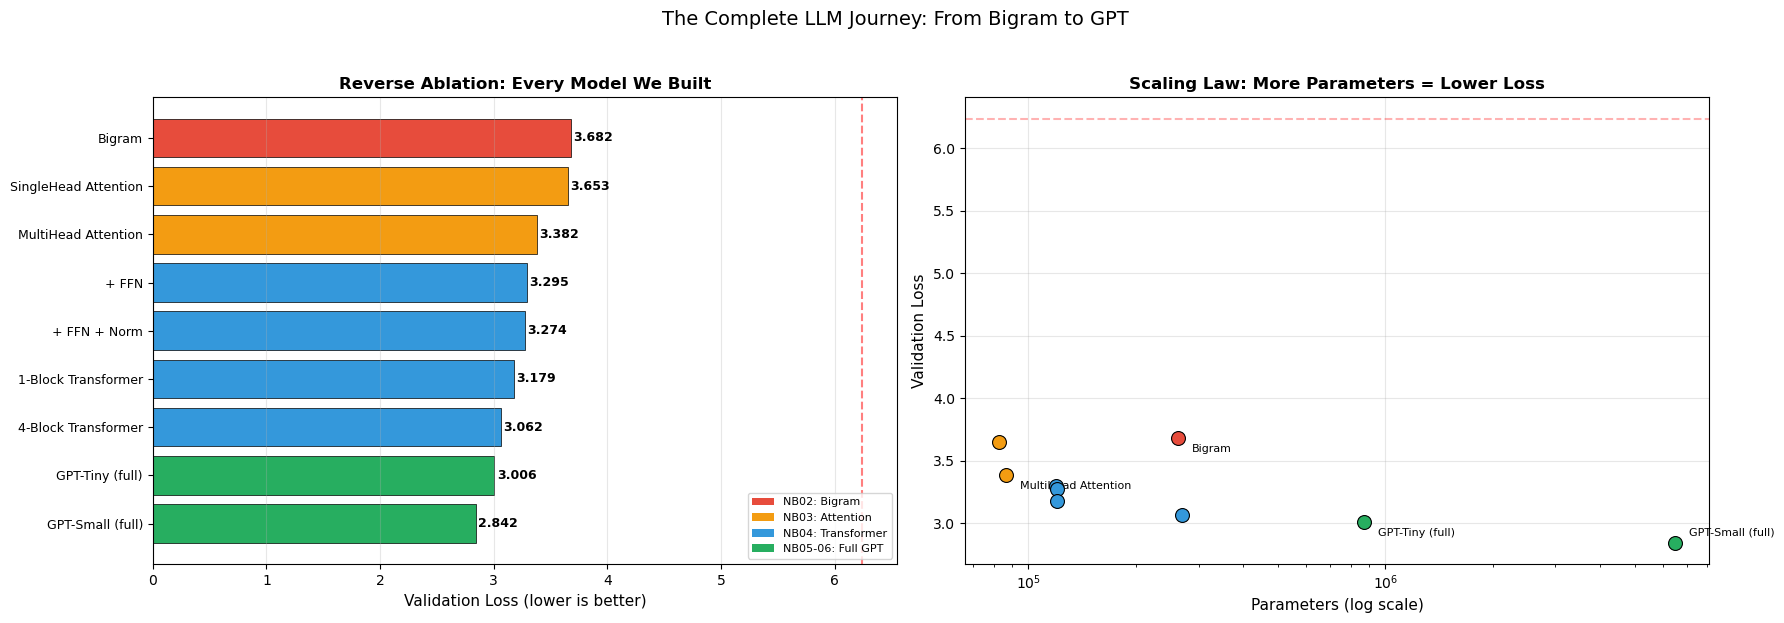

In [26]:
# Comprehensive ablation visualization

sorted_metrics = sorted(all_metrics, key=lambda x: x["val_loss"], reverse=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Panel 1: Horizontal bar chart of val loss ---
ax = axes[0]
model_names = [m["model"] for m in sorted_metrics]
val_losses_all = [m["val_loss"] for m in sorted_metrics]
param_counts = [m["parameters"] for m in sorted_metrics]

# Color by notebook origin
colors = []
for name in model_names:
    if 'Bigram' in name:
        colors.append('#e74c3c')
    elif 'SingleHead' in name or 'MultiHead' in name:
        colors.append('#f39c12')
    elif 'FFN' in name or 'Norm' in name or '1-Block' in name or '4-Block' in name:
        colors.append('#3498db')
    elif 'GPT' in name:
        colors.append('#27ae60')
    else:
        colors.append('gray')

bars = ax.barh(range(len(model_names)), val_losses_all, color=colors, edgecolor='black', linewidth=0.5)

for i, (bar, v) in enumerate(zip(bars, val_losses_all)):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f'{v:.3f}', va='center', fontsize=9, fontweight='bold')

random_loss = math.log(tokenizer.vocab_size)
ax.axvline(x=random_loss, color='red', linestyle='--', alpha=0.5, label=f'Random ({random_loss:.2f})')

ax.set_yticks(range(len(model_names)))
ax.set_yticklabels(model_names, fontsize=9)
ax.set_xlabel('Validation Loss (lower is better)', fontsize=11)
ax.set_title('Reverse Ablation: Every Model We Built', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_items = [
    Patch(facecolor='#e74c3c', label='NB02: Bigram'),
    Patch(facecolor='#f39c12', label='NB03: Attention'),
    Patch(facecolor='#3498db', label='NB04: Transformer'),
    Patch(facecolor='#27ae60', label='NB05-06: Full GPT'),
]
ax.legend(handles=legend_items, fontsize=8, loc='lower right')

# --- Panel 2: Loss vs Parameters (scaling law) ---
ax = axes[1]
for i, m in enumerate(sorted_metrics):
    ax.scatter(m["parameters"], m["val_loss"], s=100, color=colors[i],
               edgecolor='black', linewidth=0.8, zorder=3)
    # Label a few
    if m["model"] in ("Bigram", "MultiHead Attention", "GPT-Tiny (full)", "GPT-Small (full)"):
        offset = (10, -10) if 'Small' not in m["model"] else (10, 5)
        ax.annotate(m["model"], (m["parameters"], m["val_loss"]),
                    textcoords='offset points', xytext=offset, fontsize=8)

ax.set_xscale('log')
ax.set_xlabel('Parameters (log scale)', fontsize=11)
ax.set_ylabel('Validation Loss', fontsize=11)
ax.set_title('Scaling Law: More Parameters = Lower Loss', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=random_loss, color='red', linestyle='--', alpha=0.3)

plt.suptitle('The Complete LLM Journey: From Bigram to GPT', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

In [27]:
# Print the ablation table
bigram_val = next(m["val_loss"] for m in all_metrics if m["model"] == "Bigram")

print("=" * 80)
print("REVERSE ABLATION: Building an LLM One Component at a Time")
print("=" * 80)
print(f"\n{'#':<4} {'Model':<35} {'Params':>10} {'Val Loss':>10} {'vs Bigram':>10}")
print("-" * 72)

for i, m in enumerate(sorted_metrics, 1):
    delta = m["val_loss"] - bigram_val
    marker = "  <-- baseline" if m["model"] == "Bigram" else ""
    print(f"{i:<4} {m['model']:<35} {m['parameters']:>10,} "
          f"{m['val_loss']:>10.4f} {delta:>+10.4f}{marker}")

best = sorted_metrics[-1]
improvement = bigram_val - best["val_loss"]
print(f"\nBest model: {best['model']}")
print(f"Total improvement over bigram: {improvement:.4f} ({improvement/bigram_val*100:.1f}% reduction)")

REVERSE ABLATION: Building an LLM One Component at a Time

#    Model                                   Params   Val Loss  vs Bigram
------------------------------------------------------------------------
1    Bigram                                 262,144     3.6823    +0.0000  <-- baseline
2    SingleHead Attention                    82,432     3.6529    -0.0293
3    MultiHead Attention                     86,528     3.3818    -0.3005
4    + FFN                                  119,616     3.2947    -0.3876
5    + FFN + Norm                           119,872     3.2743    -0.4080
6    1-Block Transformer                    120,000     3.1788    -0.5035
7    4-Block Transformer                    269,184     3.0621    -0.6201
8    GPT-Tiny (full)                        873,216     3.0062    -0.6761
9    GPT-Small (full)                     6,507,008     2.8415    -0.8407

Best model: GPT-Small (full)
Total improvement over bigram: 0.8407 (22.8% reduction)


## 8. What Each Component Contributed

Looking back across all 6 notebooks, here is the story of how we built an LLM:

In [28]:
# Narrative summary with the contribution of each component

print("=" * 80)
print("THE JOURNEY: What Each Component Added")
print("=" * 80)

contributions = [
    ("NB02: Bigram Baseline",
     "Just a lookup table. No context at all.",
     "Baseline -- pure memorization of token-pair frequencies"),
    ("NB03: + Self-Attention",
     "Tokens can now look at previous tokens.",
     "The BIGGEST single jump -- context is everything"),
    ("NB03: + Multi-Head Attention",
     "Multiple attention patterns in parallel.",
     "Different heads learn different relationship types"),
    ("NB04: + Feed-Forward Network",
     "Nonlinear processing after attention.",
     "Attention gathers info, FFN processes it"),
    ("NB04: + LayerNorm",
     "Stabilize activations between layers.",
     "Small effect alone, critical for depth"),
    ("NB04: + Residual Connections",
     "Skip connections for gradient flow.",
     "Enables training deep networks"),
    ("NB04: + Depth (4 blocks)",
     "Stack multiple transformer blocks.",
     "More blocks = more rounds of reasoning"),
    ("NB05-06: + Full GPT Training",
     "Weight tying, scaled init, LR schedule, AdamW.",
     "Good training matters as much as good architecture"),
    ("NB06: + Scale (GPT-Small)",
     "8 layers, 256 d_model, 6.5M params.",
     "The scaling law: more parameters = lower loss"),
]

for i, (name, what, insight) in enumerate(contributions, 1):
    print(f"\n  {i}. {name}")
    print(f"     What: {what}")
    print(f"     Why:  {insight}")

print("\n" + "=" * 80)
print("The key insight: self-attention is the most impactful single component")
print("(it gives the model CONTEXT), but every other component plays a crucial")
print("supporting role. Remove any one, and quality suffers.")

THE JOURNEY: What Each Component Added

  1. NB02: Bigram Baseline
     What: Just a lookup table. No context at all.
     Why:  Baseline -- pure memorization of token-pair frequencies

  2. NB03: + Self-Attention
     What: Tokens can now look at previous tokens.
     Why:  The BIGGEST single jump -- context is everything

  3. NB03: + Multi-Head Attention
     What: Multiple attention patterns in parallel.
     Why:  Different heads learn different relationship types

  4. NB04: + Feed-Forward Network
     What: Nonlinear processing after attention.
     Why:  Attention gathers info, FFN processes it

  5. NB04: + LayerNorm
     What: Stabilize activations between layers.
     Why:  Small effect alone, critical for depth

  6. NB04: + Residual Connections
     What: Skip connections for gradient flow.
     Why:  Enables training deep networks

  7. NB04: + Depth (4 blocks)
     What: Stack multiple transformer blocks.
     Why:  More blocks = more rounds of reasoning

  8. NB05-06: +

In [29]:
# Final generation comparison
print("=" * 80)
print("FINAL OUTPUT: Best GPT Model (temperature=0.8, top_k=40)")
print("=" * 80)

model_small.eval()
for i in range(3):
    start = torch.zeros((1, 1), dtype=torch.long, device=device)
    gen = model_small.generate(start, max_new_tokens=300, temperature=0.8, top_k=40)
    print(f"\n--- Sample {i+1} ---")
    print(tokenizer.decode(gen[0].tolist()))
model_small.train()

FINAL OUTPUT: Best GPT Model (temperature=0.8, top_k=40)

--- Sample 1 ---
 ;
Thy fond valour is queen in the Tower:
The Tybalt shall go with thee; and safe alone,
And, for a little prepared, or post,
To whom it be so enrid the table of them
By two will begun of mistakes. First, good lady!
In this the very wounds that action
Prithee, awake, that most falsely of blood
But this tongue is nothing expiration,
And so I apprehended by such greetings
And that will stay intellious strength behind
From sacred private in the gross of you.

PRINCE EDWARD:
In all this night will have visit you in this;
For every which you shall bear
Do as well the swords of Lewis of Buckingham.

PRINCE EDWARD:

--- Sample 2 ---
 , sweet must against me;
Look to then, I beseech you, and that is fall
Of what you have done, sir, if you did not
With a great great task: but it have done,
As you accounted men are reloud it,
With full of fainty tribunes down: but as he
When you have made cursed in their beneding;
For thi

GPT(
  (token_emb): Embedding(512, 256)
  (pos_emb): Embedding(256, 256)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (W_qkv): Linear(in_features=256, out_features=768, bias=False)
        (W_o): Linear(in_features=256, out_features=256, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, 

## Summary: What We Built

Across 6 notebooks, we built a **complete language model from absolute scratch**:

| Notebook | Component | Key Learning |
|----------|-----------|-------------|
| **01** | BPE Tokenizer | Text to numbers via learned merges |
| **02** | Bigram Baseline | Simplest LM; why context matters |
| **03** | Self-Attention | Q/K/V mechanism; how models see context |
| **04** | Transformer Block | FFN, LayerNorm, residuals; the full block |
| **05** | GPT Architecture | Weight tying, initialization, clean design |
| **06** | Training & Scaling | LR schedule, generation, scale matters |

### The Scaling Law in Action
More parameters + more data + more compute = better predictions. This simple relationship drives the entire field of large language models.

### Where to Go From Here
- **More data**: OpenWebText, FineWeb, or The Pile for diverse training
- **GPU training**: Move to CUDA for 10-100x speedup
- **Bigger models**: Scale to 100M+ parameters
- **Modern tricks**: RoPE, GQA (grouped-query attention), SwiGLU, flash attention
- **Fine-tuning**: Instruction tuning, RLHF to turn a base model into a chatbot
- **Evaluation**: Perplexity, BLEU, human evaluation of generated text